In [26]:
using JLD2, NeuralVerification, ReachabilityAnalysis, Plots
using ReachabilityAnalysis: solve

In [9]:
@load "/home/mforets/.julia/dev/NeuralNetworkAnalysis/models/Sherlock-Benchmark-7/b7.jld2" controller

1-element Array{Symbol,1}:
 :controller

In [10]:
controller

Network(NeuralVerification.Layer[NeuralVerification.Layer{ReLU,Float64}([0.163975 -0.365692 -0.110607; 0.00788866 -0.0073386 -0.00646295; … ; 0.150818 0.0725213 -0.0701961; -0.0219663 -0.00101078 -0.00424137], [1.17824, -0.0114979, -0.167934, -0.0891668, -0.0123961, 0.976735, -0.0847619, 0.783389, -0.154641, -0.0660713  …  -0.0798815, -0.0914616, -0.297625, 0.66794, -0.0866732, -0.1021, -0.132668, -0.0859026, -0.126276, -0.0638604], ReLU()), NeuralVerification.Layer{ReLU,Float64}([-0.0413785 -0.099273 … -0.23012 -0.118602; 0.289409 -0.0438496 … -0.243984 -0.00251692; … ; 0.678618 0.152153 … -0.13858 -0.00100734; 0.0493884 -0.205044 … -0.0745542 0.0687402], [0.347177, 1.40696, 0.0880149, 0.133021, 0.0939945, 0.0862833, 0.0865589, 0.1, 0.561748, 0.593956  …  1.25761, 0.1, 0.355777, 0.346134, 0.105879, 0.593527, 0.0621325, 0.33789, 1.74347, 0.592779], ReLU()), NeuralVerification.Layer{ReLU,Float64}([-0.0257408 0.103618 … 0.264587 -0.0182079], [2.65223], ReLU())])

In [ ]:
LazySets.rectify

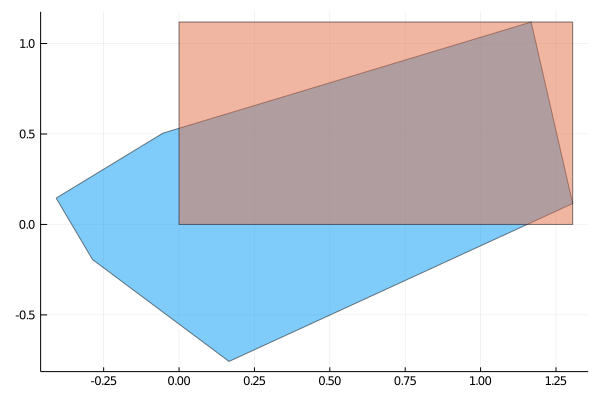

In [130]:
A = rand(VPolytope, dim=2)
plot(A)
plot!(LazySets.rectify(overapproximate(A, Hyperrectangle)))

In [143]:
# FIRST LAYER
W = controller.layers[1].weights
b = controller.layers[1].bias
Y = overapproximate(W*X₀ ⊕ b, Hyperrectangle)
Z = rectify(Y)

# SECOND LAYER
W = controller.layers[2].weights
b = controller.layers[2].bias
Y = overapproximate(W*Z ⊕ b, Hyperrectangle)
Z = rectify(Y)

# OUTPUT LAYER
W = controller.layers[3].weights
b = controller.layers[3].bias
Y = overapproximate(W*Z ⊕ b, Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([84.1867593026886], [6.8246124913068495])

In [144]:
overapproximate(Y, Interval)

Interval{Float64,IntervalArithmetic.Interval{Float64}}([77.3621, 91.0114])

In [230]:
@taylorize function f!(dx, x, p, t)
    x₁, x₂, x₃, w, u = x

    dx[1] = x₃^3 - x₂ + w
    dx[2] = x₃
    dx[3] = u
    dx[4] = zero(w) # w
    dx[5] = zero(u) # u
    return dx
end

In [179]:
solver = MaxSens(resolution=100.0, tight=true)

MaxSens
  resolution: Float64 100.0
  tight: Bool true


In [224]:
X₀ = Hyperrectangle(low=[0.35, 0.45, 0.25], high=[0.45, 0.55, 0.35])
W₀ = Interval(0, 0) # Interval(-0.01, 0.01)

U₀ = Interval(0, 0)
#U₀ = forward_network(solver, controller, X₀)

Q₀ = X₀ × W₀ × U₀
#Q₀ = overapproximate(Q₀, Hyperrectangle)
#Q₀ = split(Q₀, 4*ones(Int, 5))
prob = @ivp(x' = f!(x), dim: 5, x(0) ∈ Q₀);

Tsample = 0.5 # sect
t0 = 0.0
ti = t0
k = 1

sol1 = solve(prob, tspan=(ti, ti+k*Tsample), alg=TMJets(abs_tol=1e-16, orderT=8, orderQ=1));
sol1z = overapproximate(sol1, Zonotope);
length(sol1z)

1

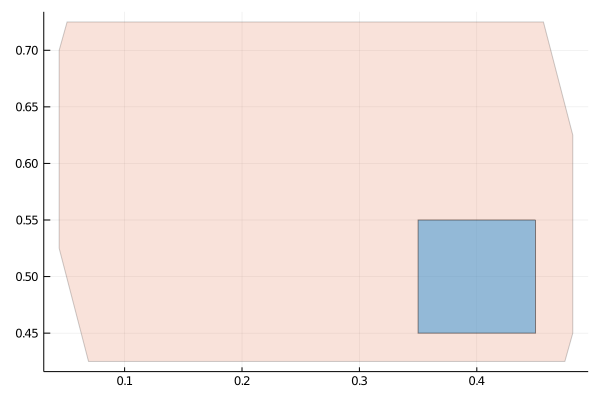

In [225]:
plot(convert(HPolytope, LazySets.project(X₀, [1, 2])))

plot!(sol1z, vars=(1, 2), alpha=.2)

In [226]:
T₀ = set(Projection(sol1z[end], vars=[1,2,3]))
W₀ = Interval(0, 0) # Interval(-0.01, 0.01)

U₀ = Interval(0, 0)
U₀ = forward_network(solver, controller, X₀)

Q₀ = T₀ × W₀ × U₀
#Q₀ = overapproximate(Q₀, Hyperrectangle)
#Q₀ = split(Q₀, 4*ones(Int, 5))
prob = @ivp(x' = f!(x), dim: 5, x(0) ∈ Q₀);

ti = 0.5
k = 2

sol2 = solve(prob, tspan=(ti, ti+k*Tsample), alg=TMJets(abs_tol=1e-16, orderT=8, orderQ=1));
sol2z = overapproximate(sol2, Zonotope);

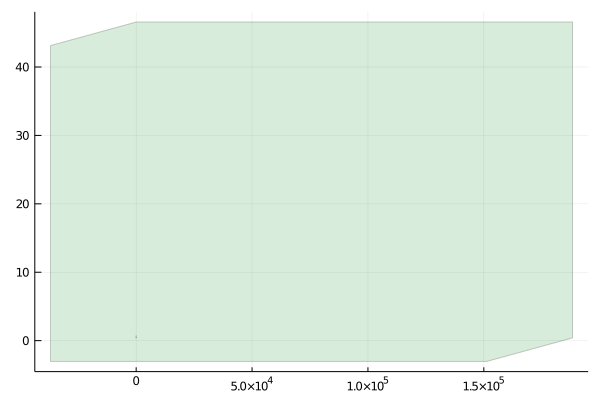

In [227]:
plot(convert(HPolytope, LazySets.project(X₀, [1, 2])), color=:red)
plot!(sol1z, vars=(1, 2), alpha=.2)
plot!(sol2z, vars=(1, 2), alpha=.2)

In [228]:
T₀ = set(Projection(sol2z[end], vars=[1,2,3]))
W₀ = Interval(0, 0) # Interval(-0.01, 0.01)

U₀ = Interval(0, 0)
#U₀ = forward_network(solver, controller, X₀)

Q₀ = T₀ × W₀ × U₀
#Q₀ = overapproximate(Q₀, Hyperrectangle)
#Q₀ = split(Q₀, 4*ones(Int, 5))
prob = @ivp(x' = f!(x), dim: 5, x(0) ∈ Q₀);

ti = 1.0
k = 3

sol3 = solve(prob, tspan=(ti, ti+k*Tsample), alg=TMJets(abs_tol=1e-16, orderT=8, orderQ=1));
sol3z = overapproximate(sol3, Zonotope);

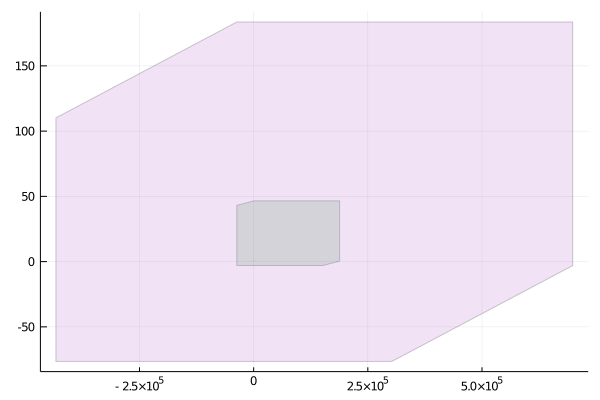

In [229]:
plot(convert(HPolytope, LazySets.project(X₀, [1, 2])), color=:red)
plot!(sol1z, vars=(1, 2), alpha=.2)
plot!(sol2z, vars=(1, 2), alpha=.2)
plot!(sol3z, vars=(1, 2), alpha=.2)

In [221]:
T₀ = set(Projection(sol3z[end], vars=[1,2,3]))
W₀ = Interval(0, 0) # Interval(-0.01, 0.01)

U₀ = Interval(0, 0)
#U₀ = forward_network(solver, controller, X₀)

Q₀ = T₀ × W₀ × U₀
#Q₀ = overapproximate(Q₀, Hyperrectangle)
#Q₀ = split(Q₀, 4*ones(Int, 5))
prob = @ivp(x' = f!(x), dim: 5, x(0) ∈ Q₀);

ti = 1.5
k = 4

sol4 = solve(prob, tspan=(ti, ti+k*Tsample), alg=TMJets(abs_tol=1e-16, orderT=8, orderQ=1));
sol4z = overapproximate(sol4, Zonotope);

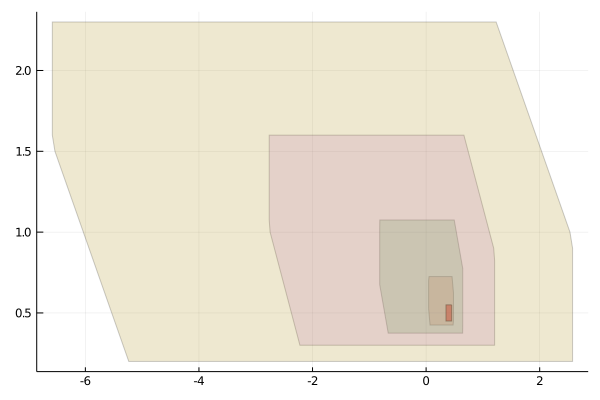

In [222]:
plot(convert(HPolytope, LazySets.project(X₀, [1, 2])), color=:red)
plot!(sol1z, vars=(1, 2), alpha=.2)
plot!(sol2z, vars=(1, 2), alpha=.2)
plot!(sol3z, vars=(1, 2), alpha=.2)
plot!(sol4z, vars=(1, 2), alpha=.2)